<a href="https://colab.research.google.com/github/monarkparekh/MAE-598__Design-Optimization/blob/Assignment-4/MAE_598__Design_Optimization_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h1><center>MAE 598 Design Optimization: 
Assignment 4</center></h1></b>

<h3><center>Name: Monark Parekh <br>
ASU ID: 1222179426</center></h3>


<h3><b>Question 1</b></h3>

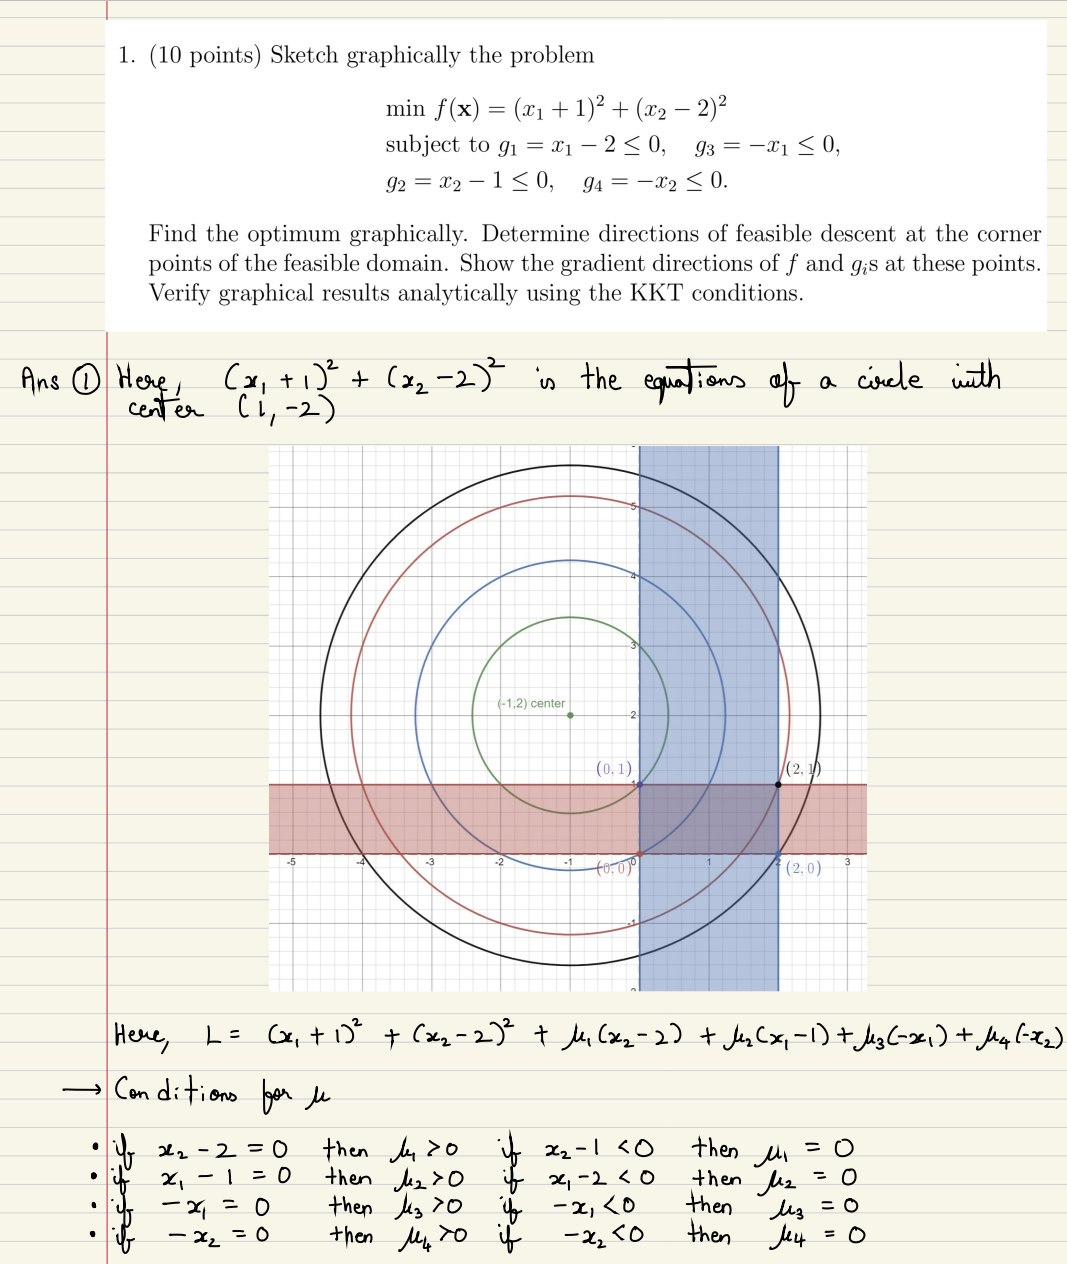

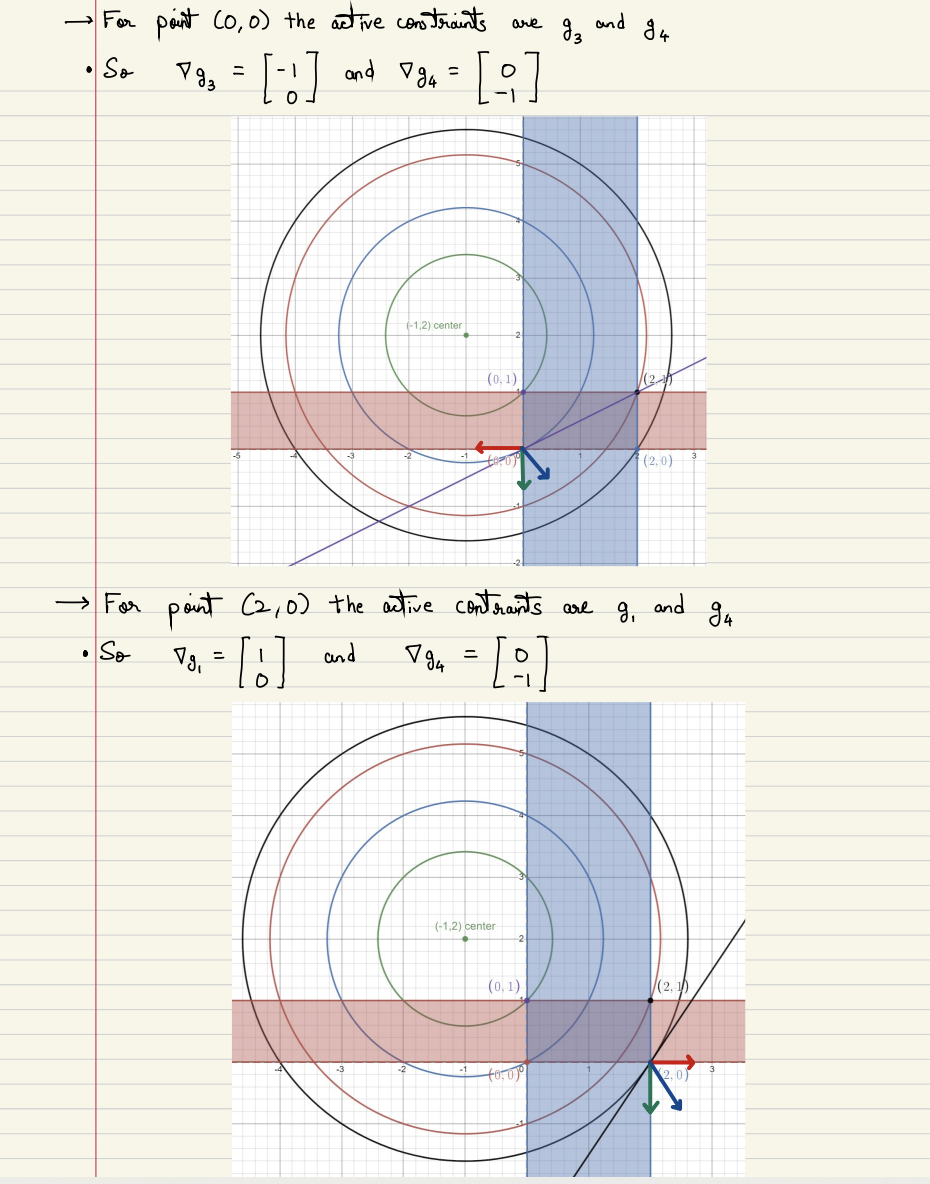

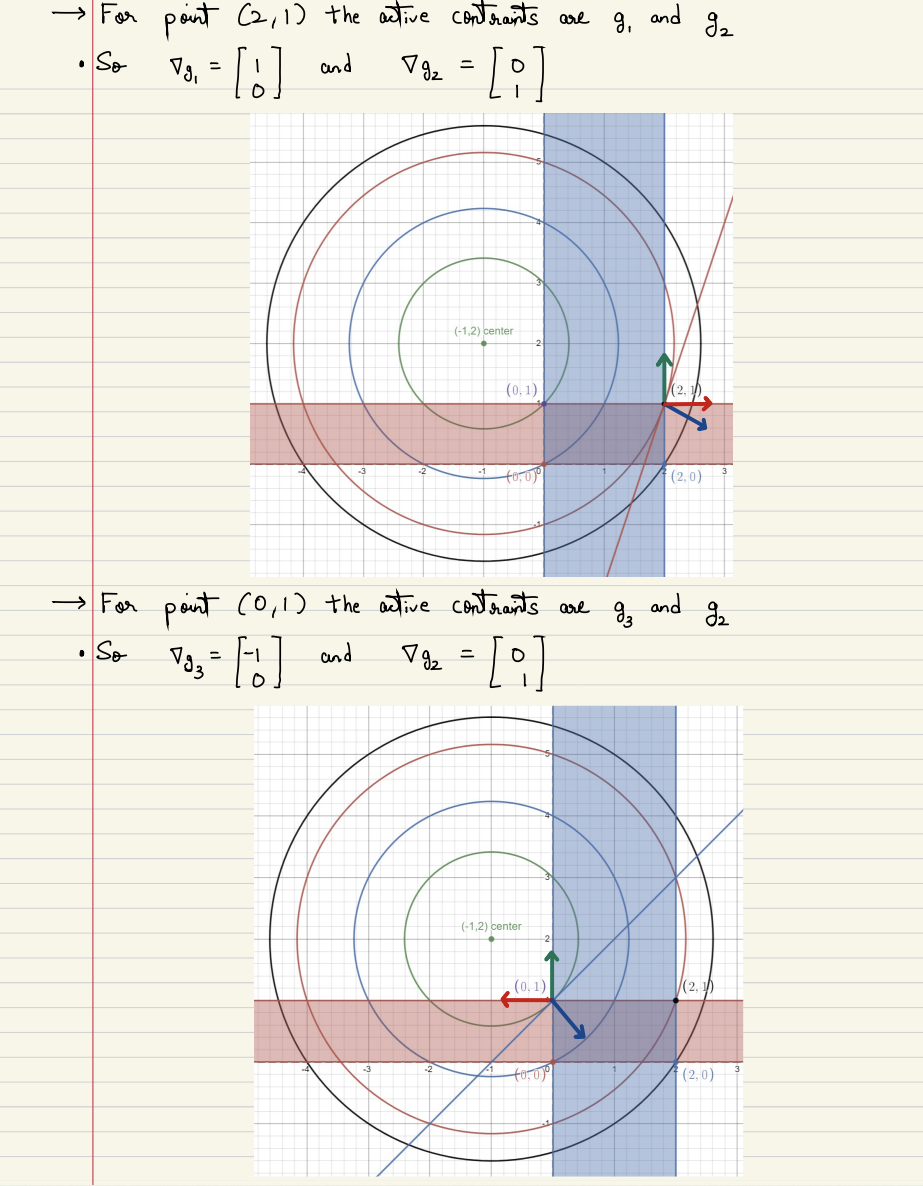

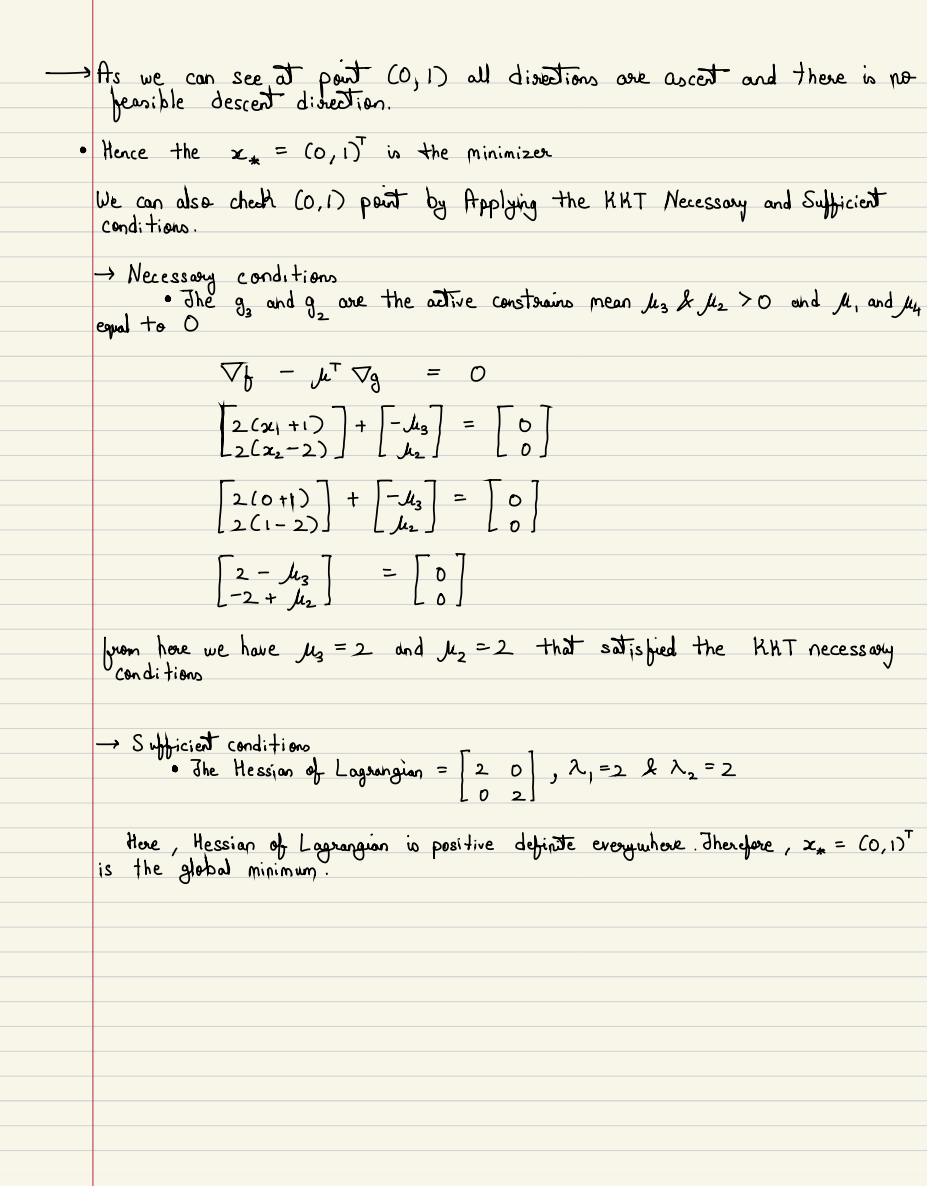

<h3><b>Question 2</b></h3>

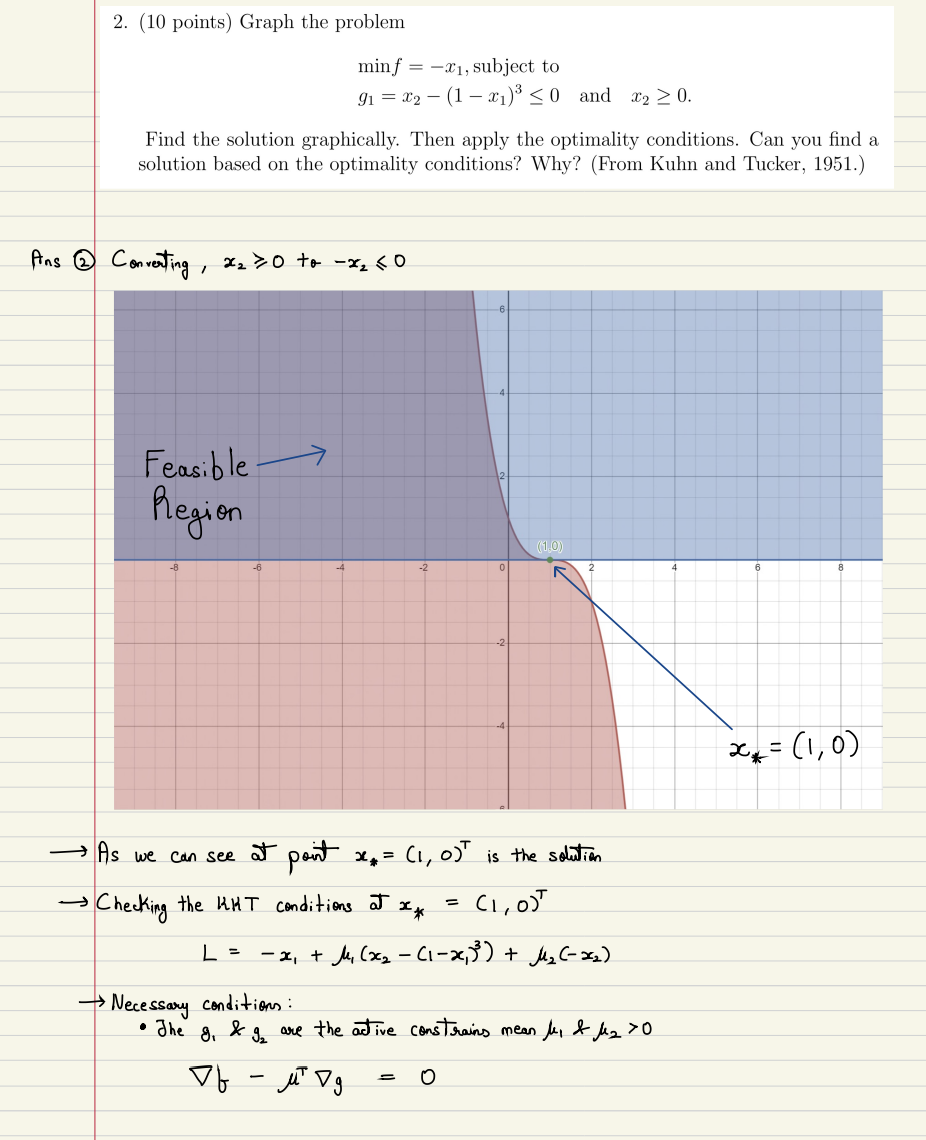

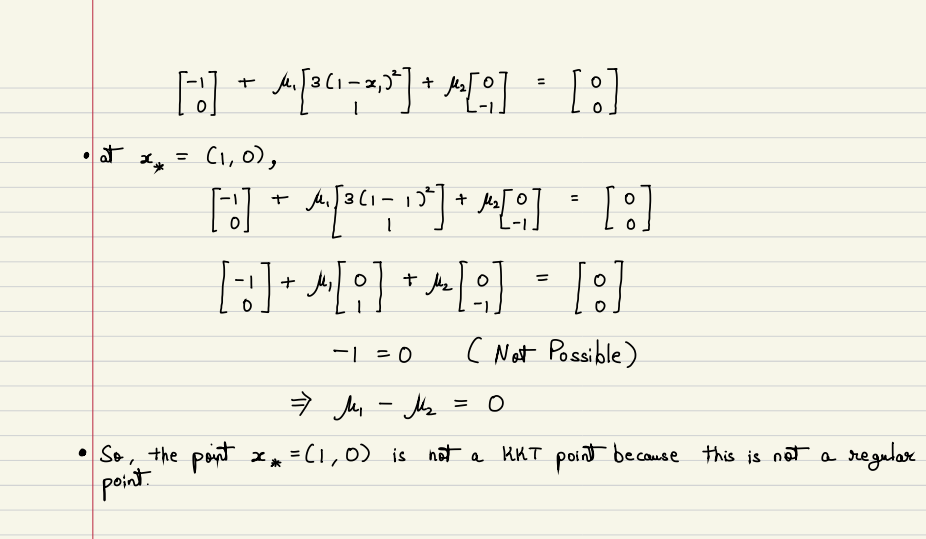

<h3><b>Question 3</b></h3>

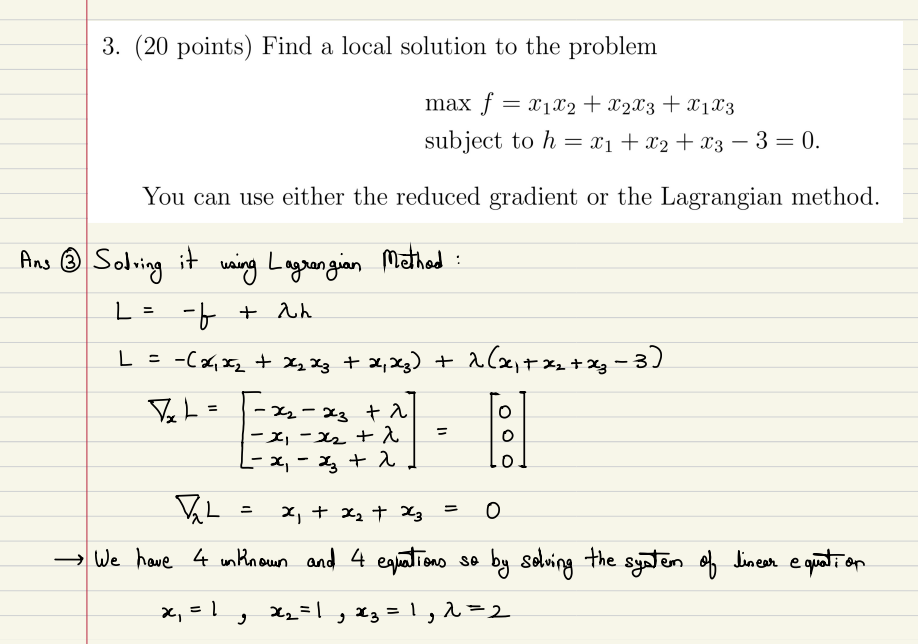

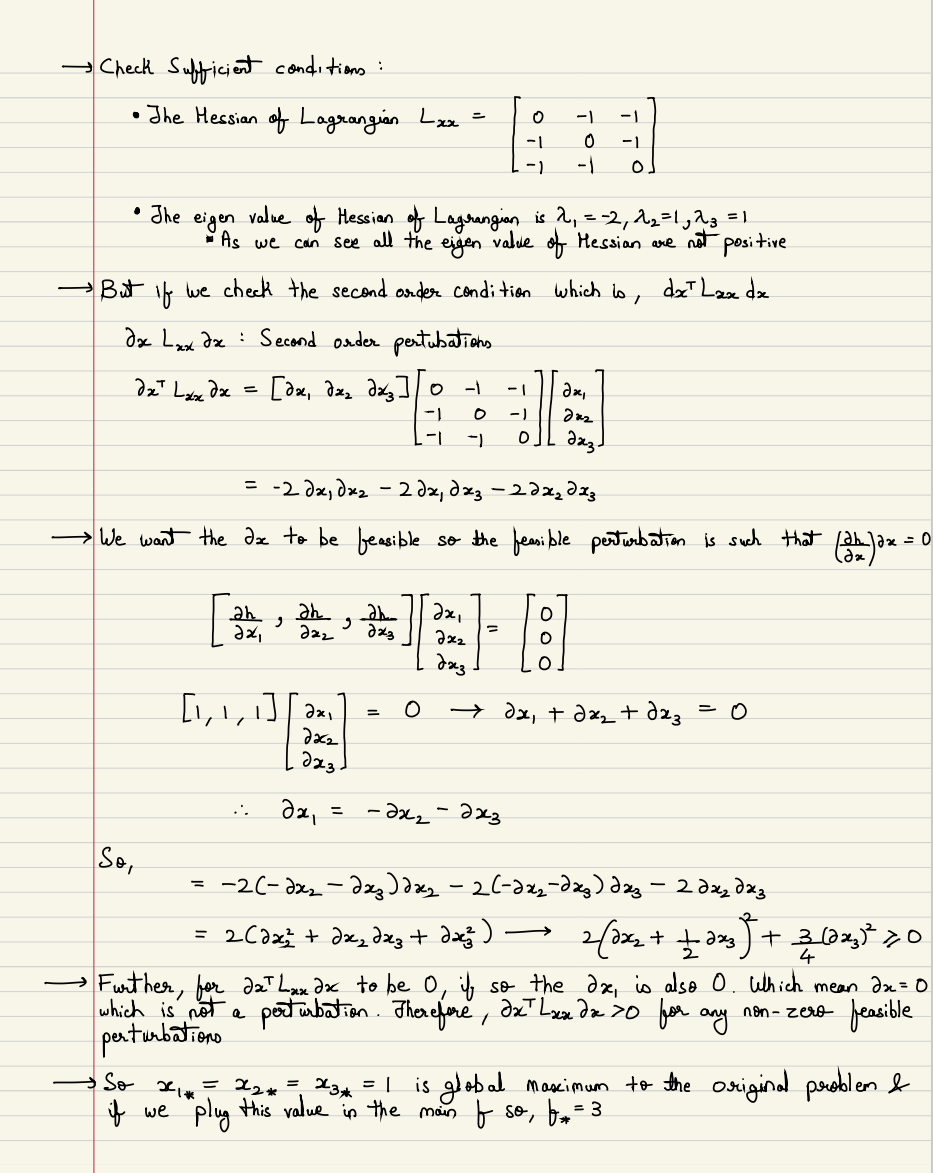

<h3><b>Question 4</b></h3>

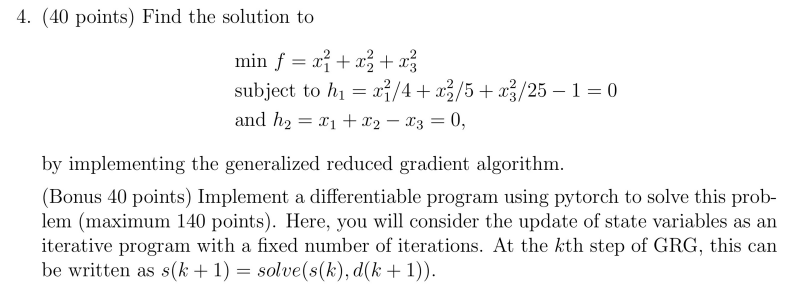

<h3><b>Importing Necessary Librabries</b></h3>

In [55]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd.functional import jacobian
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')

<h3><b>Defining the objective function and constraints</b></h3>

In [56]:
# Defining the objective fucntion
Function = lambda X: ((X[0] ** 2) + (X[1] ** 2) + (X[2] ** 2))

# Defining the Constraints
Constraint1_h1 = lambda X: (((X[0] ** 2) / 4) + ((X[1] ** 2) / 5) + ((X[2] ** 2) / 25) - 1)
Constraint2_h2 = lambda X: (X[0] + X[1] - X[2])

# Initializing the Variables
X = Variable(torch.tensor([1.,1.,1.]), requires_grad=True)
eps= 1e-03

<h3>For the given problem we have 3 equations and 2 constraints. Thus, n = 3 and m =2.
<br>Therefore, the degree of freedom (d.o.f) = n - m = 3 - 2 = 1
<br>Based on the values of d.o.f, m and n, we can conclude that the their is one decision variable and two state variables.
<br>Decision Variable (d) = x1
<br>State Variable (s) = [x2, x3] </h3>

<h3><b>Calculating the Reduced Gradient</b></h3>

In [57]:
# Calculating Reduced Gradient using 'jacobian'
def Reduced_Gradient_Calc(f, h1, h2, X):
  # Computing the Jacobian using the jacobian function
  Jacobian = torch.zeros((3, 3))
  Jacobian[0] = jacobian(f, (X))
  Jacobian[1] = jacobian(h1, (X))
  Jacobian[2] = jacobian(h2, (X))

  # Variables used to calculate Reduced Gradient
  df_dd = Jacobian[0, 0]   # del 'f' by del 'd'
  df_ds = Jacobian[0,1:]   # del 'f' by del 's'
  dh_ds = Jacobian[1:,1:]  # del 'h' by del 's'
  dh_dd = Jacobian[1:,0]   # del 'h' by del 'd'

  # Computing the Reduced Gradient
  reduced_gradient = df_dd - torch.matmul(torch.matmul(df_ds, torch.pinverse(dh_ds)), dh_dd)
  
  return reduced_gradient, df_dd, df_ds, dh_ds, dh_dd

<h3><b>Using the "Levenberg -Marquardt" method and Newtons Method to Solve Constraints</b></h3>

In [58]:
def Constraint_Solver(X):
    Lambda = 1.
    normal_error = torch.norm(torch.tensor([Constraint1_h1(X), Constraint2_h2(X)]))
    while normal_error > 1e-06:
        reduced_gradient, df_dd, df_ds, dh_ds, dh_dd = Reduced_Gradient_Calc(Function, Constraint1_h1, Constraint2_h2, X)
        with torch.no_grad():
            X[1:] = X[1:] - torch.matmul(
                torch.matmul(torch.pinverse(torch.matmul(dh_ds.T, dh_ds) + Lambda * torch.eye(2)), dh_ds.T),
                torch.tensor([Constraint1_h1(X), Constraint2_h2(X)]))
        normal_error = torch.norm(torch.tensor([Constraint1_h1(X), Constraint2_h2(X)]))
    return X

<h3><b>Defining the Line Search Algorithm</b></h3>

In [59]:
def Updater(X, alpha):
    new_X = torch.zeros(3)
    reduced_gradient, df_dd, df_ds, dh_ds, dh_dd = Reduced_Gradient_Calc(Function, Constraint1_h1, Constraint2_h2, X)
    new_X[0] = X[0] - alpha * reduced_gradient
    new_X[1:] = X[1:] + (alpha * (torch.matmul(torch.pinverse(dh_ds), dh_dd)) * reduced_gradient)
    return new_X


def lineSearch(X):
    t = 0.5
    counter = 25
    reduced_gradient, df_dd, df_ds, dh_ds, dh_dd = Reduced_Gradient_Calc(Function, Constraint1_h1, Constraint2_h2, X)
    alpha = 1
    i = 0
    func = Function(Updater(X, alpha))
    phi = Function(X) - (t * alpha * (reduced_gradient ** 2))
    while func > phi and i < counter:
        alpha = 0.5 * alpha
        func = Function(Updater(X, alpha))
        phi = Function(X) - (t * alpha * (reduced_gradient ** 2))
        i += 1
    return alpha

<h3><b>Defining the Generalized Reduced Gradient Algorithm</b></h3>

In [60]:
def Generalized_Reduced_Gradient(X, eps=1e-03):
    X_val = X.detach().numpy()
    print(f'Initial value of X = {X_val}')
    X = Constraint_Solver(X)
    print(f'\nUsing the Constraint Solver to determine the feasible solution\nX_feasible = {X}')
    X_val = np.vstack((X_val, X.detach().numpy()))
    all_obj_func_values = [Function(X).item()]
    alpha_val = [1]
    reduced_gradient, df_dd, df_ds, dh_ds, dh_dd = Reduced_Gradient_Calc(Function, Constraint1_h1, Constraint2_h2, X)
    error_value = torch.norm(reduced_gradient)
    all_error_values = [error_value]
    iterations = 0
    while error_value > eps:
        alpha = lineSearch(X)  # step 4.1
        reduced_gradient, df_dd, df_ds, dh_ds, dh_dd = Reduced_Gradient_Calc(Function, Constraint1_h1, Constraint2_h2, X)

        with torch.no_grad():
            X[0] = X[0] - alpha * reduced_gradient  # setp 4.2
            X[1:] = X[1:] + (alpha * np.matmul(torch.pinverse(dh_ds), dh_dd) * reduced_gradient)  # step 4.3

        X = Constraint_Solver(X)  # step 4.4
        error_value = torch.norm(reduced_gradient)  # step 4.5

        # record values
        X_val = np.vstack((X_val, X.detach().numpy()))
        all_obj_func_values.append(Function(X).item())
        alpha_val.append(alpha)
        all_error_values.append(error_value)
        iterations += 1
    return X_val, all_obj_func_values, alpha_val, all_error_values, iterations

In [61]:
X_val, objFun_val, alpha_val,error_Val,k = Generalized_Reduced_Gradient(X)

Initial value of X = [1. 1. 1.]

Using the Constraint Solver to determine the feasible solution
X_feasible = tensor([1.0000, 1.5614, 2.5614], requires_grad=True)


<h3><b>Results</b></h3>

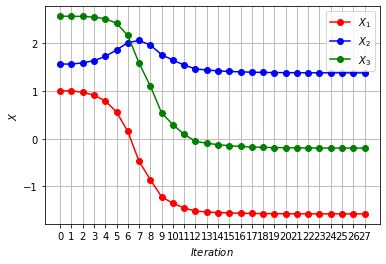

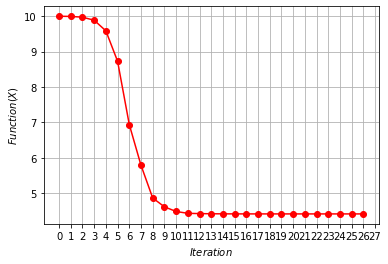

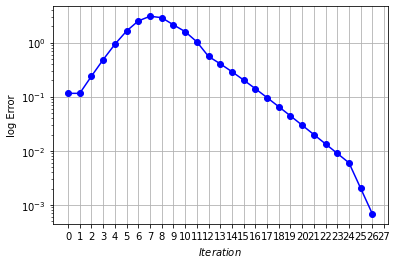

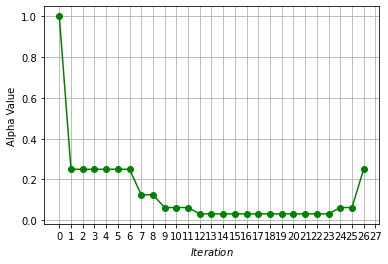

In [62]:
# Plotting the Results

print("\n")
plt.plot(X_val[:,0],'ro-')
plt.plot(X_val[:,1],'bo-')
plt.plot(X_val[:,2],'go-')
plt.grid(True)
plt.legend(["$X_1$" ,"$X_2$","$X_3$"])
plt.xlabel("$Iteration$")
plt.ylabel("$X$")
plt.xticks(range(len(X_val[:,0])))
plt.show()

print("\n")
plt.plot(objFun_val,'ro-')
plt.grid(True)
plt.xlabel("$Iteration$")
plt.ylabel("$Function(X)$")
plt.xticks(range(len(X_val[:,0])))
plt.show()

print("\n")
plt.plot(error_Val,'bo-')
plt.grid(True)
plt.xlabel("$Iteration$")
plt.yscale("log")
plt.ylabel(r'log Error')
plt.xticks(range(len(X_val[:,0])))
plt.show()

print("\n")
plt.plot(alpha_val,'go-')
plt.grid(True)
plt.xlabel("$Iteration$")
plt.ylabel(r'Alpha Value')
plt.xticks(range(len(X_val[:,0])))
plt.show()

<h3><b>Conclusion</b></h3>

In [63]:
print("\nFinal Result is as follows\n")
print(f'For a total number of {k} iterations, we get an optimal solution of \n{X.detach().numpy()}')
print(f'\nThe Function value at the optimal solution is {Function(X)}')


Final Result is as follows

For a total number of 26 iterations, we get an optimal solution of 
[-1.5738866  1.3768967 -0.1969896]

The Function value at the optimal solution is 4.411768913269043


<h3><b>Question 5</b></h3>

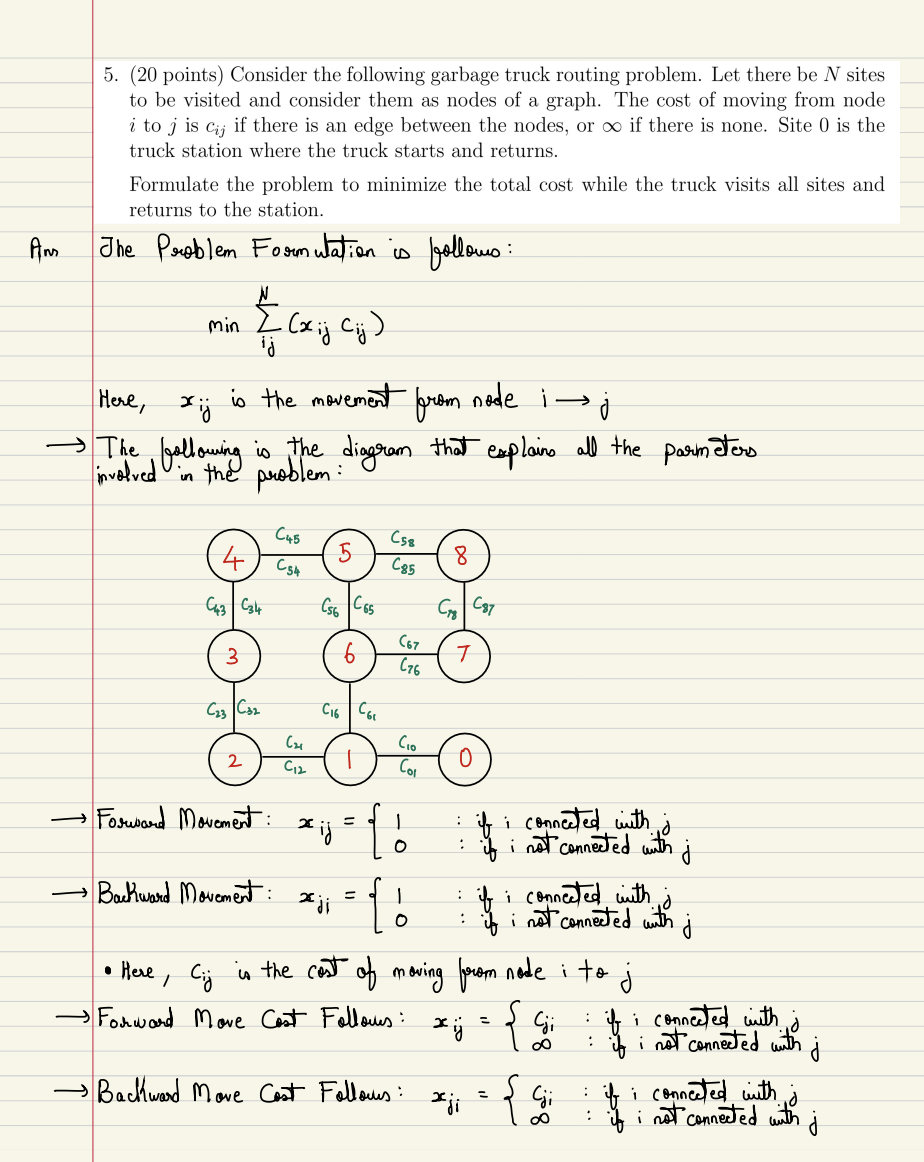

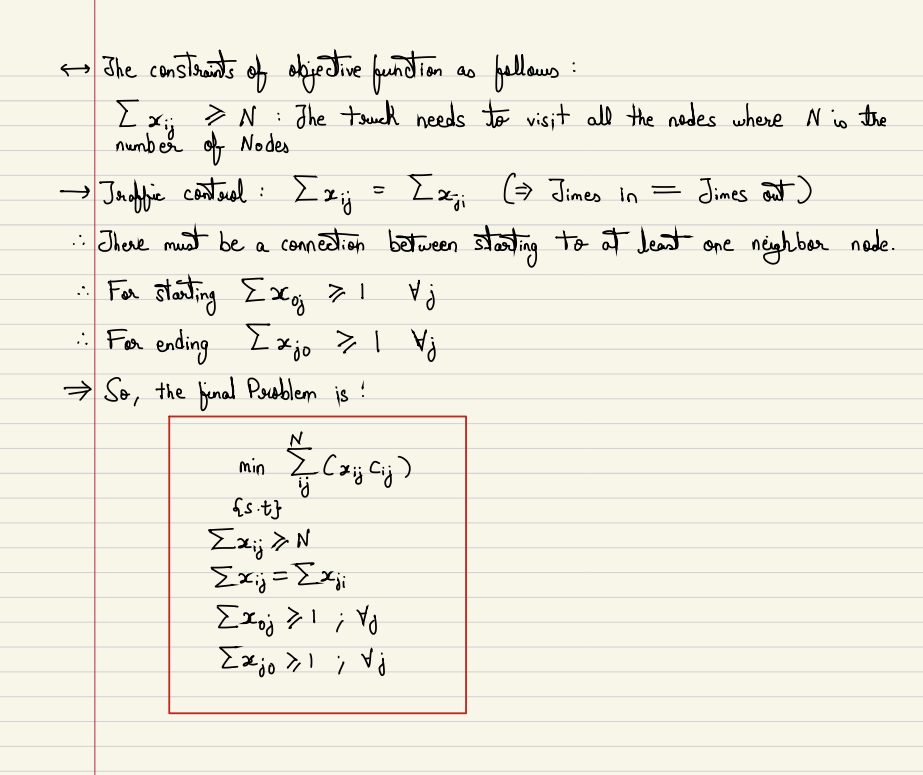